In [1]:
import pandas as pd
import numpy as np
import glob
import re
from functools import reduce
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data

Files HE, LP, TP, ALL_Others.csv contain the data for prediction. 

Requirements for building the model: 
predictors to use (Timestamp, Heat_exchanger_stuffing, … , Product_Throughput) and target variable is Energy costs. 


In [2]:
path_to_data = '/home/marianna/etc/data/'

In [3]:
datafiles = {
    re.sub('{path}|.{extension}'.format(path=path_to_data, extension='csv'), '', filename.lower()
          ) :pd.read_csv(filename, sep=';') for filename in glob.glob('{path}*'.format(path=path_to_data))
}

In [4]:
{filename: datafiles.get(filename).columns.to_list() for filename in list(datafiles.keys())}

{'all_others': ['Timestamp',
  'Efficiency_of_main_aggregate',
  'Quality_of_raw_materials',
  'Outdoor_temperature',
  'Product_Throughput'],
 'tp': ['Timestamp', 'Top_pressure_in_hydralic_system'],
 'test': ['ID',
  'Timestamp',
  'Heat_exchanger_stuffing',
  'Losses_of_pressure_in_hydralic_system',
  'Top_pressure_in_hydralic_system',
  'Efficiency_of_main_aggregate',
  'Quality_of_raw_materials',
  'Outdoor_temperature',
  'Product_Throughput'],
 'lp': ['Timestamp', 'Losses_of_pressure_in_hydralic_system'],
 'he': ['Timestamp', 'Heat_exchanger_stuffing'],
 'ec': ['Timestamp', 'Energy_costs']}

In [5]:
#checking files dimensionality
{filename: datafiles.get(filename).shape for filename in datafiles.keys()}

{'all_others': (365, 5),
 'tp': (365, 2),
 'test': (61, 9),
 'lp': (365, 2),
 'he': (365, 2),
 'ec': (304, 2)}

File with target variable is smaller than other values 

In [6]:
test = datafiles.get('test')

In [7]:
#too many duplicates after merge
filenames_without_test_target = [key for key in datafiles.keys() if key not in ['ec', 'test']]
train_dfs_list = [datafiles.get(filename) for filename in filenames_without_test_target]

reduce(lambda x, y: pd.merge(x, y, on = 'Timestamp'), train_dfs_list).shape

(13846145, 8)

In [8]:
train_data = pd.DataFrame()
train_data = datafiles.get('ec').merge(datafiles.get('lp'), on='Timestamp', how='left'
                                      ).merge(datafiles.get('he'), on='Timestamp', how='left'
                                             ).merge(datafiles.get('tp'), on='Timestamp', how='left'
                                                    ).merge(datafiles.get('all_others'), 
                                                            on='Timestamp', how='left')

In [9]:
#after merging all the files checking whether features correspond one to another
[col for col in train_data.columns if col not in test.columns]

['Energy_costs']

In [10]:
#initializing target variable
target = 'Energy_costs'
predictors = test.drop(
    [col_to_remove for col_to_remove in test.columns if col_to_remove in ['ID', 'Timestamp', target]], axis=1
).columns

In [11]:
dataset_dtypes = pd.concat([
    pd.DataFrame(train_data.dtypes, columns=['train_col_type']),
    pd.DataFrame(test.dtypes, columns=['test_col_type'])
], axis=1, sort=False)

dataset_dtypes[dataset_dtypes['train_col_type'] != dataset_dtypes['test_col_type']]

,train_col_type,test_col_type
Energy_costs,float64,NaN
Top_pressure_in_hydralic_system,object,float64
ID,NaN,int64


# Data preprocessing

In [12]:
try:
    train_data['Top_pressure_in_hydralic_system'] = train_data['Top_pressure_in_hydralic_system'].map(float)
except ValueError as exception:
    print('Error message: {}'.format(exception))

Error message: could not convert string to float: 'n/A'


In [13]:
def preprocess_data(df): 
    """Convert data types - dates from string to timestamps and string symbols for float conversion."""
    proc_df = df.copy(deep=True)
    proc_df['Timestamp'] = proc_df['Timestamp'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))
    proc_df['Top_pressure_in_hydralic_system'] = proc_df['Top_pressure_in_hydralic_system'
                                                        ].replace('n/A', None).map(float)
    return proc_df

In [14]:
train_data = preprocess_data(train_data)
test = preprocess_data(test)

# EDA

In [15]:
def check_timespan(df, timedate_col_name='Timestamp'):
    max_date = max(df[timedate_col_name])
    min_date = min(df[timedate_col_name])
    timespan = max_date - min_date
    records_freq = df.reset_index(drop=False).groupby([timedate_col_name]
                                          ).count().rename(columns={'index':'records_numb'}
                                                          ).records_numb.unique()
    diff_btw_dates = list(np.unique(np.diff(list(df[timedate_col_name]))))
    
    print('Earliest date: {}'.format(min_date),
         '\nLatest date: {}'.format(max_date),
         '\nDataset timespan: {}'.format(timespan),
         '\nRecords number per day: {}'.format(records_freq),
         '\nDifferences between dates of records: {}'.format(diff_btw_dates))   

Dataset stores one recording of state of the things per day. It has updates every day (no missing dates) - both in train and test samples.

In [16]:
check_timespan(train_data)

Earliest date: 2017-01-01 00:00:00 
Latest date: 2017-10-31 00:00:00 
Dataset timespan: 303 days 00:00:00 
Records number per day: [1] 
Differences between dates of records: [Timedelta('1 days 00:00:00')]


In [17]:
check_timespan(test)

Earliest date: 2017-11-01 00:00:00 
Latest date: 2017-12-31 00:00:00 
Dataset timespan: 60 days 00:00:00 
Records number per day: [1] 
Differences between dates of records: [Timedelta('1 days 00:00:00')]


In [18]:
def check_features_dist(train_df, test_df, features_to_check, 
                        figwidth=30, figtheight=15, 
                        train_df_plot_color='blue', test_df_plot_color='orange'):
    fig = plt.figure(figsize=(figtheight, figwidth))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i, feature in enumerate(features_to_check):    
        j = i + 1
        ax = fig.add_subplot(9, 3, j)
        
        try:
            sns.distplot(train_df[feature].dropna(), color=train_df_plot_color)
        except KeyError:
            print('Error. No {feature_name} feature in the Train sample'.format(feature_name=feature))
            
        try:
            sns.distplot(test_df[feature].dropna(), color=test_df_plot_color)
        except KeyError:
            print('Error. No {feature_name} feature in the Test sample'.format(feature_name=feature))
            
        plt.legend(labels=['train','test'])

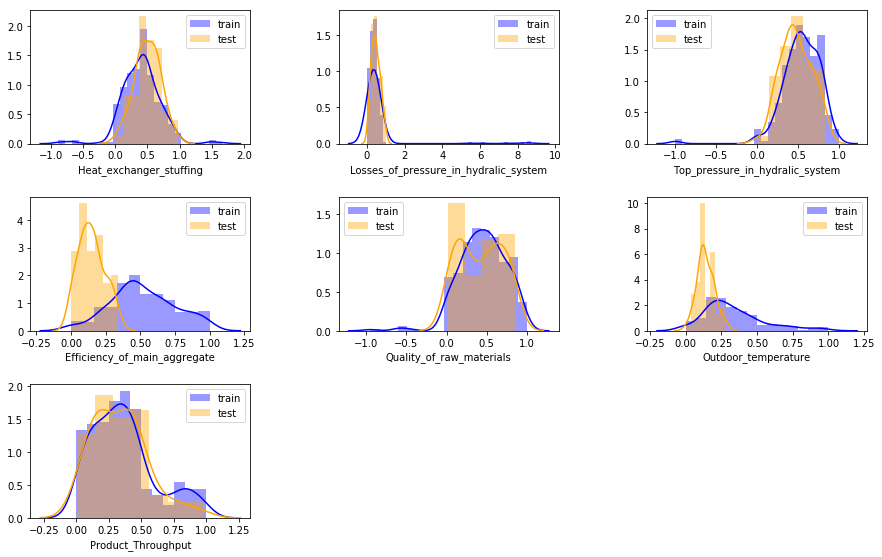

In [344]:
check_features_dist(train_data, test, predictors)

Significant changes in distribution can be noticed for features 'Efficiency_of_main_aggregate' and 'Outdoor_temperature'

In [19]:
def check_nan_vals(df, features_to_check):
    null_features = pd.DataFrame.from_dict(
        {feature: df[df[feature].isnull()].shape[0] for feature in features_to_check}, 
        orient='index', columns=['n_null_features'])
    n_records = df.shape[0]
    null_features['n_null_features_%'] = null_features['n_null_features'
                                                      ].apply(lambda x: (x / n_records)*100)
    return null_features

In [20]:
check_nan_vals(train_data, predictors)

,n_null_features,n_null_features_%
Heat_exchanger_stuffing,3,0.986842
Losses_of_pressure_in_hydralic_system,1,0.328947
Top_pressure_in_hydralic_system,4,1.315789
Efficiency_of_main_aggregate,9,2.960526
Quality_of_raw_materials,8,2.631579
Outdoor_temperature,8,2.631579
Product_Throughput,0,0.000000


In [57]:
def fill_missing_values(df, features, method):
    df_vals = df.copy(deep=True)    
    if method == 'mean':
        for feature in features:
            df_vals[feature] = df_vals[feature].fillna(np.mean(df_vals[feature]))
    elif method == 'zero':
        for feature in features:
            df_vals[feature] = df_vals[feature].fillna(0)
            
    return df_vals

# Modelling

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

In [94]:
def rmse(estimator, data_sample, features, target):
    """Get RMSE score for given data sample."""
    predicted = estimator.predict(data_sample[features])
    actual = data_sample[target]
    return sqrt(mean_squared_error(actual, predicted))

def rmse_on_samples(estimator, train_sample, test_sample, features, target,
                   return_as_dict=False):
    """Get RMSE scores for both samples - test and train.
    """
    if return_as_dict:
        return {'RMSE_train': rmse(estimator, train_sample, features, target),
               'RMSE_test': rmse(estimator, test_sample, features, target)}
    else:
        print('RMSE on train:', rmse(estimator, train_sample, features, target))
        print('RMSE on test:', rmse(estimator, test_sample, features, target))
        return None

In [95]:
train, validate = train_test_split(
    fill_missing_values(train_data, predictors, method='zero'), 
    test_size=0.20, random_state=42)

train_mean, validate_mean = train_test_split(
        fill_missing_values(train_data, predictors, method='mean'), 
    test_size=0.20, random_state=42)

In [96]:
train.shape, validate.shape

((243, 9), (61, 9))

In [97]:
baseline_mdl_1 = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None
                                 ).fit(train[predictors], train[target])

rmse_on_samples(baseline_mdl_1, train, validate, predictors, target)

RMSE on train: 4.565145984061737
RMSE on test: 4.400304546781327


In [63]:
baseline_mdl_2 = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None
                                 ).fit(train_mean[predictors], train_mean[target])

rmse_on_samples(baseline_mdl_2, train_mean, validate_mean, predictors, target)

RMSE on train: 4.588440540198621
RMSE on test: 4.547658893931291


Dataset with missing values substituted by mean values performs slightly worse (RMSE value is higher)

In [84]:
def test_estimators(train_sample, test_sample, features, target, print_estimator_hyperparams=False,
                   estimators=[Lasso(), Ridge(), ElasticNet()]):
    """Mini-pipeline for testing various estimators baseline models."""
    
    for estimator in estimators:
        print('\nTraining {estimator_name}...'.format(estimator_name=type(estimator).__name__))
        if print_estimator_hyperparams:
            print(estimator)
        trained_estimator = estimator.fit(train_sample[features], train_sample[target])
        rmse_on_samples(trained_estimator, train_sample, test_sample, features, target, return_as_dict=True)

In [85]:
test_estimators(train, validate, predictors, target)


Training Lasso...
RMSE on train: 4.867521143024085
RMSE on test: 4.366118817096333

Training Ridge...
RMSE on train: 4.565874101551014
RMSE on test: 4.377693331890543

Training ElasticNet...
RMSE on train: 4.8372637646972985
RMSE on test: 4.330611072597726


In [86]:
test_estimators(train_mean, validate_mean, predictors, target)


Training Lasso...
RMSE on train: 4.860048915855082
RMSE on test: 4.360377367150631

Training Ridge...
RMSE on train: 4.589241086982382
RMSE on test: 4.5166739653795975

Training ElasticNet...
RMSE on train: 4.831124716745029
RMSE on test: 4.327386540954429


ElasticNet performs better than other estimators for both datasets. Dataset with mean values replacing the missing ones produces lower RMSE values on both train and validate subsets.

In [149]:
#set of model hyperparameters to test
ElasticNet_estimators = [
    ElasticNet(l1_ratio=0, selection='cyclic'), 
    ElasticNet(l1_ratio=1, selection='cyclic'),
    ElasticNet(l1_ratio=0.5, selection='cyclic'), 
    ElasticNet(l1_ratio=0, selection='random'), 
    ElasticNet(l1_ratio=1, selection='random'),
    ElasticNet(l1_ratio=0.5, selection='random')]

In [174]:
def test_estimators(train_sample, test_sample, features, target, estimators):
    """Mini-pipeline for testing various estimators baseline models."""     
    rmse_res, estimators_hyperparams = [], []
    for estimator in estimators:
        trained_estimator = train_converging_estimator(estimator, train_sample, features, target)
        estimators_hyperparams.append(trained_estimator)
        rmse_scores = rmse_on_samples(
            trained_estimator, train_sample, test_sample, features, target, return_as_dict=True)
        rmse_res.append(rmse_scores)
        
    metrics = pd.DataFrame(rmse_res)
    metrics['model_hyperparam'] = estimators_hyperparams
    return metrics

def train_converging_estimator(estimator, data_sample, features, target):
    """Train estimators. If the model fails to converge increase max_iter number."""
    with warnings.catch_warnings():
        try:
            trained_estimator = estimator.fit(data_sample[features], data_sample[target])
            return trained_estimator
        except Warning:
            cur_max_iter = estimator.get_params().get('max_iter')
            if cur_max_iter < 10000: #condition to stop recursion
                upd_max_iter = cur_max_iter + 500                
                train_converging_estimator(estimator.set_params(max_iter=upd_max_iter), 
                                           data_sample, features, target)
            else:
                trained_estimator = estimator.fit(data_sample[features], data_sample[target])
                return trained_estimator


In [180]:
metrics = test_estimators(train, validate, predictors, target, ElasticNet_estimators)
mean_metrics = test_estimators(train_mean, validate_mean, predictors, target, ElasticNet_estimators)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [186]:
metrics.sort_values(['RMSE_test', 'RMSE_train'], ascending=True)

,RMSE_test,RMSE_train,model_hyperparam
3,4.306289,4.792609,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
0,4.306289,4.792609,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
2,4.330611,4.837264,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
5,4.330611,4.837264,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
1,4.366119,4.867521,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
4,4.366119,4.867521,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."


In [184]:
mean_metrics.sort_values(['RMSE_test', 'RMSE_train'], ascending=True)

,RMSE_test,RMSE_train,model_hyperparam
0,4.321969,4.798767,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
3,4.321969,4.798767,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
2,4.327387,4.831125,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
5,4.327387,4.831125,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
1,4.360377,4.860049,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
4,4.360377,4.860049,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."


In [206]:
best_mdl = list(
    metrics.sort_values(['RMSE_test', 'RMSE_train'], ascending=True
                       ).head(1).model_hyperparam)[0]

In [207]:
best_mdl.fit(train[predictors], train[target])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='random', tol=0.0001, warm_start=False)

# Analysis

To-do:
1. Build a model on the provided dataset to predict energy costs using 
2. Provide scores for the dataset in test.csv file and write to 'Predicted' coumn.

RMSE should be considered to be the main metric for models evaluation.

In [220]:
import pickle

def save_to_pickle(model, pickle_name):
    model_pkl_filename = pickle_name
    model_pkl = open(model_pkl_filename, 'wb')
    pickle.dump(model, model_pkl)
    model_pkl.close()   

In [215]:
test['Predicted'] = best_mdl.predict(test[predictors])

In [216]:
test.head(3)

,ID,Timestamp,Heat_exchanger_stuffing,Losses_of_pressure_in_hydralic_system,Top_pressure_in_hydralic_system,Efficiency_of_main_aggregate,Quality_of_raw_materials,Outdoor_temperature,Product_Throughput,Predicted
0,1,2017-11-01,0.571023,0.100396,0.378605,0.316781,0.645509,0.179519,0.164037,11.963334
1,2,2017-11-02,0.378231,0.498550,0.643957,0.298548,0.194245,0.183721,0.208933,11.563898
2,3,2017-11-03,0.421636,0.799595,0.821323,0.094372,0.853556,0.130573,0.317198,11.520759


In [217]:
test.to_csv('test.csv', index=False)

In [226]:
save_to_pickle(best_mdl, 'fin_mdl_to_deploy.pkl')